# Exploring the usefulness of lyrics for learning language

In [1]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize

In [43]:
af_sl = pd.read_excel('audio_features_and_clean_lyrics.xlsx')
eng_span_profanity = pd.read_excel('English and Spanish profanity.xlsx')

## Profane word count

In [74]:
eng_span_profanity['English profanity'] = eng_span_profanity['English profanity'].str.lower()
eng_span_profanity['Spanish profanity'] = eng_span_profanity['Spanish profanity'].str.lower()

In [77]:
merged_profanity = eng_span_profanity['English profanity'].tolist() + eng_span_profanity['Spanish profanity'].tolist()

In [92]:
af_sl['Lyrics'] = af_sl['Lyrics'].str.lower().str.split()

In [93]:
def count_mean_words(lyrics):
    if isinstance(lyrics, list):
        count = 0
        for word in lyrics:
            if word in merged_profanity:
                count += 1
        return count
    else:
        return 0

af_sl['Profane word count'] = af_sl['Lyrics'].apply(count_mean_words)


In [95]:
af_sl['Word Count'] = af_sl['Lyrics'].apply(lambda x: len(str(x).split()))


In [98]:
af_sl['% of non profance words'] = ((af_sl['Word Count'] - af_sl['Profane word count']) / af_sl['Word Count']) * 100

## Exploring whether instrumentalness and speechiness are good metrics

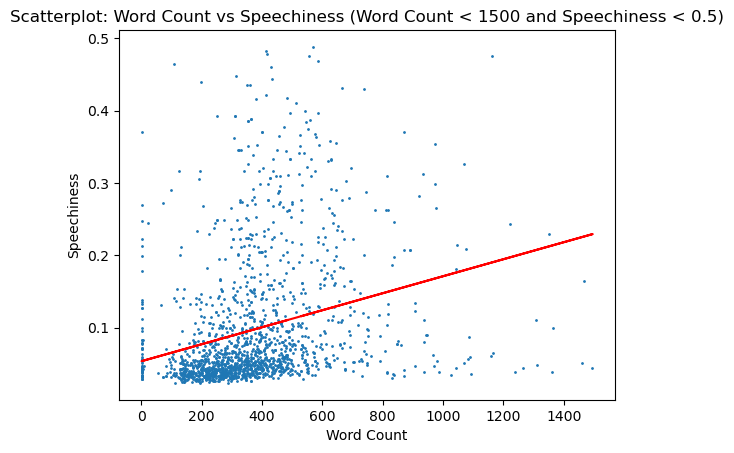

In [14]:
import numpy as np

x = exc_outliers['Word Count']
y = exc_outliers['Speechiness']

plt.scatter(x, y, s=1)
plt.xlabel('Word Count')
plt.ylabel('Speechiness')
plt.title('Word Count vs Speechiness (Word Count < 1500 and Speechiness < 0.5)')

# Perform linear regression
slope, intercept = np.polyfit(x, y, 1)
regression_line = slope * x + intercept

# Plot the regression line
plt.plot(x, regression_line, color='red')

plt.show()


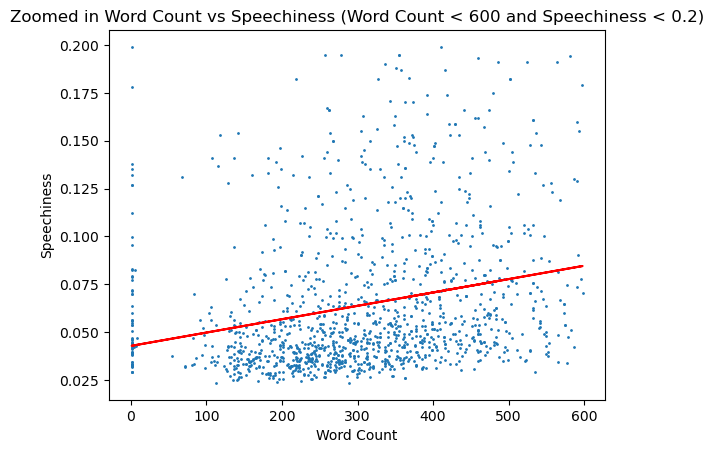

In [17]:
zoomed_in = exc_outliers[(exc_outliers['Word Count'] < 600) & (exc_outliers['Speechiness'] < 0.2)]

x = zoomed_in['Word Count']
y = zoomed_in['Speechiness']

plt.scatter(x, y, s=1)
plt.xlabel('Word Count')
plt.ylabel('Speechiness')
plt.title('Zoomed in Word Count vs Speechiness (Word Count < 600 and Speechiness < 0.2)')

# Perform linear regression
slope, intercept = np.polyfit(x, y, 1)
regression_line = slope * x + intercept

# Plot the regression line
plt.plot(x, regression_line, color='red')

plt.show()

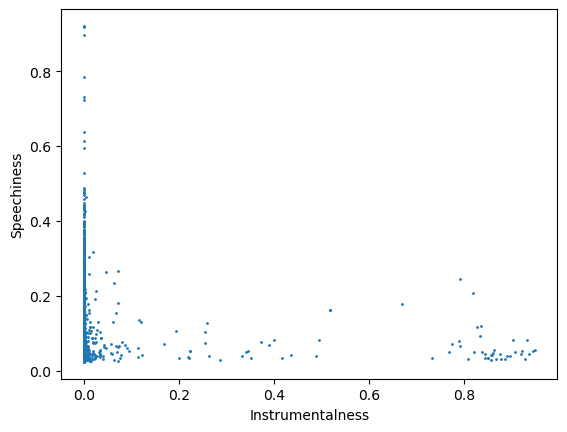

In [20]:
plt.scatter(af_sl['Instrumentalness'], af_sl['Speechiness'], s=1)
plt.xlabel('Instrumentalness')
plt.ylabel('Speechiness')
plt.show()

## What speed of lyrics is optimal for learning?

Test whether the speed of a song is too quick using duration_ms and words per song to calculate the speed
Use this information to rank the songs, then listen to them and set an optimal range for thenumber of words per minute. Songs which exceed this do not need to be discarded but they should be slowed down


In [101]:
#calculating minute per song and words per minute
af_sl['minutes'] = af_sl['Duration_ms'] / (1000 * 60)
af_sl['words / minute'] = af_sl['Word Count'] / af_sl['minutes']

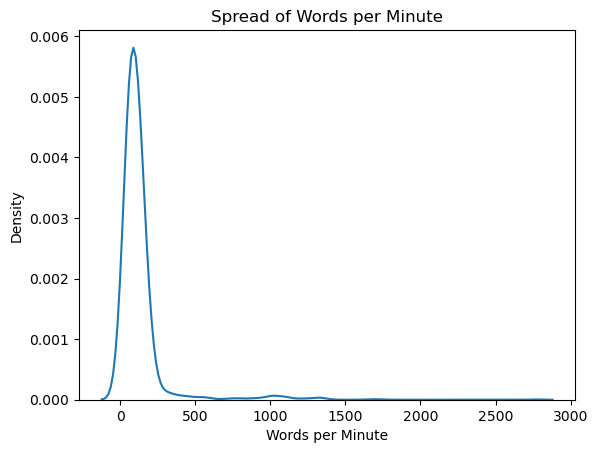

In [41]:
import seaborn as sns

sns.kdeplot(af_sl['words / minute'])
plt.xlabel('Words per Minute')
plt.ylabel('Density')
plt.title('Spread of Words per Minute')
plt.show()

<Axes: xlabel='words / minute', ylabel='Density'>

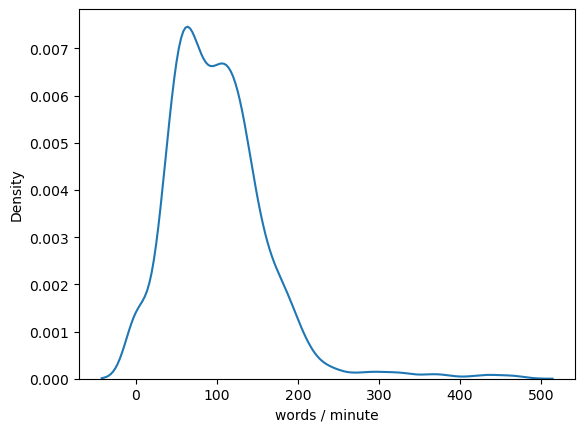

In [43]:
filtered_songs = af_sl[af_sl['words / minute'] <= 500]
sns.kdeplot(filtered_songs['words / minute'])


In [102]:
af_sl['words / minute'].describe()

count    1698.000000
mean      129.230127
std       181.899271
min         0.109263
25%        59.353204
50%        97.343520
75%       134.181817
max      2756.735582
Name: words / minute, dtype: float64

Logic and ranking for the speed and number of lyrics in a song to use in the classifier. The best speed music for Spanish learners should be slightly skewed lower than the mean number of words per minute. This is because excessively fast music will be difficult for the learner to process. As such music I've based my ranking on the interquartile range over the mean. The higher the score the better speed the song is.

- 0.0 for music over 200 words / minute & under 20
- 0.5 for music between 20 - 60 & 135 - 200
- 1.0 for music between 60 - 135 words / minute



In [103]:
def calculate_speed_ranking(wpm):
    if wpm > 200 or wpm < 20:
        return 0.0
    elif 20 <= wpm <= 60 or 135 <= wpm <= 200:
        return 0.5
    elif 60 <= wpm <= 135:
        return 1.0
    else:
        return None  

af_sl['Speed Ranking'] = af_sl['words / minute'].apply(calculate_speed_ranking)

## Spanglish

In [139]:
af_sl_ = pd.read_excel('audio_features_and_clean_lyrics.xlsx')

In [154]:
import pandas as pd
from langdetect import detect, LangDetectException

english_word_counts = {}  # Dictionary to store the counts of English words per song

for index, row in af_sl_.iterrows():
    song = row['Track Name']
    lyrics = row['Lyrics']
    count = 0

    if isinstance(lyrics, str):  # Check if lyrics is a string
        words = lyrics.lower().split()

        for word in words:
            try:
                if detect(word) == 'en':
                    count += 1
            except LangDetectException:
                pass

    english_word_counts[song] = count

print(english_word_counts)

{'Sin Rumbo': 33, 'Después de la Playa': 12, 'El Merengue': 2, 'Tiburon': 20, 'Mujeriego': 6, 'Arranca (feat. Omega)': 89, 'La Vaca': 5, 'Loma de Cayenas': 2, 'Tu Eres Ajena': 7, 'Tu Sonrisa': 3, 'Niña Bonita - Remastered 2020': 0, 'Vale la Pena': 71, 'Enamorame': 9, 'Guallando': 12, 'Nuestra Cancion': 3, 'Pegame Tu Vicio': 4, 'La Ventanita': 1, 'El Doctorado': 10, 'La Temperatura (feat. Eli Palacios)': 10, 'Es Mentiroso': 11, 'El Venao': 5, 'La Hora De Bailar': 9, 'La Morena': 7, 'Píntame': 4, 'Traigo Fuego': 1, 'Abusadora': 11, 'A Pedir Su Mano': 0, 'Merengue Electronico (Rompe Consola)': 8, 'Cachamba': 9, 'El Virao': 24, 'La Tanga': 8, 'Como Yo': 119, 'Morena Ven': 27, 'Nadie Se Muere': 1, 'Buscando Tus Besos': 2, 'Otra Noche (Another Night)': 38, 'Bailando por el Mundo (feat. Pitbull & El Cata)': 19, 'Pegadito Suavecito': 3, 'Tú': 30, 'Era Mentira': 3, 'Me Miras y Te Miro': 6, 'Mi Reina': 2, 'Estás Enamorada': 1, 'Oye': 9, 'Carolina': 4, 'El Africano': 1, 'Esta Canción': 22, 'La Qu

In [156]:
len(english_word_counts)

1561

In [159]:
for song, count in english_word_counts.items():
    # Check if the song exists in the dataframe
    if song in af_sl['Track Name'].values:
        # Retrieve the corresponding row and update the word count column
        af_sl.loc[af_sl['Track Name'] == song, 'Number of english words'] = count


In [161]:
af_sl['% of non-English (Spanish) words'] = (af_sl['Word Count'] - af_sl['Number of english words']) / af_sl['Word Count'] * 100

In [163]:
#topics covered and incorrect grammar? and add label 1 (poor), 2 (fine), 3 (good), 4 (excellent)
features = af_sl[['Speed Ranking', '% of non profance words', 'Track Popularity', 'Track Name', '% of non-English (Spanish) words']]
features.to_excel('song_features.xlsx', index=False)

In [164]:
features

,Speed Ranking,% of non profance words,Track Popularity,Track Name,% of non-English (Spanish) words
0,0.5,100.000000,40,Sin Rumbo,93.181818
1,1.0,99.294118,82,Después de la Playa,97.176471
2,1.0,99.416910,91,El Merengue,99.416910
3,1.0,99.181669,65,Tiburon,96.726678
4,1.0,99.310345,73,Mujeriego,97.931034
...,...,...,...,...,...
1693,0.5,98.720682,59,Requisito 420,97.014925
1694,0.5,97.755102,51,100 TRACKS,97.142857
1695,1.0,99.175824,61,Papá,98.076923
1696,0.5,99.025341,59,Toma 4,97.855750
